In [169]:
import pandas as pd
import re
import emoji
import pandas as pd
import ast
import pandas as pd
import re
from langdetect import detect
from collections import Counter
from sentencepiece import SentencePieceProcessor
import unicodedata
from collections import Counter #here e remove stop words and dont include them in frequency 
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fact_checks = pd.read_csv("Fact_check/dataset/fact_checks.csv")
posts = pd.read_csv("Fact_check/dataset/posts.csv")
pairs = pd.read_csv("Fact_check/dataset/pairs.csv")


In [171]:
posts.head(2)

,post_id,instances,ocr,verdicts,text
0,0,"[(1608571882.0, 'fb')]",[('! Dreister Impf-Fake von Markus Söder! Es i...,['False information'],NaN
1,1,"[(1586139153.0, 'fb')]","[(""!! WARNING !! A new thing circulating now. ...",['False information'],NaN


In [172]:
fact_checks.head(2)

,fact_check_id,claim,instances,title
0,0,"(' Are avocados good for you?', ' Are avocados...","[(1525653998.0, 'https://metafact.io/factcheck...",NaN
1,1,"(' Can animals have headaches?', ' Can animals...","[(1617955634.0, 'https://metafact.io/factcheck...",NaN


In [173]:
pairs.head(2)

,post_id,fact_check_id
0,2228,33
1,2228,23568


In [174]:
print(f"length of posts is {len(posts)}")
print(f"length of fact_checks is {len(fact_checks)}")
print(f"length of pairs is {len(pairs)}")

length of posts is 24431
length of fact_checks is 153743
length of pairs is 25743


In [175]:
print(f"Columns of posts is {posts.columns}")
print(f"Columns of fact_checks is {fact_checks.columns}")
print(f"Columns of pairs is {pairs.columns}")

Columns of posts is Index(['post_id', 'instances', 'ocr', 'verdicts', 'text'], dtype='object')
Columns of fact_checks is Index(['fact_check_id', 'claim', 'instances', 'title'], dtype='object')
Columns of pairs is Index(['post_id', 'fact_check_id'], dtype='object')


In [176]:
def safe_literal_eval(val):
    try:
        if isinstance(val, str):
            parsed_val = ast.literal_eval(val)
            if isinstance(parsed_val, list):
                for item in parsed_val:
                    if isinstance(item, tuple) and len(item) == 3:
                        return item  # Return the first valid tuple
            elif isinstance(parsed_val, tuple) and len(parsed_val) == 3:
                return parsed_val
        return val
    except (ValueError, SyntaxError) as e:
        print(f"Literal eval failed for {val}: {e}")
        return (None, None, None)


def split_text_column(row, row_name):
    try:
        parsed = safe_literal_eval(row[row_name])
        if isinstance(parsed, tuple) and len(parsed) == 3:
            first_text = parsed[0].strip() if isinstance(parsed[0], str) else None
            second_text = parsed[1].strip() if isinstance(parsed[1], str) else None

            # Extract the language with the highest confidence
            if isinstance(parsed[2], list) and all(isinstance(item, tuple) for item in parsed[2]):
                lang_conf = max(parsed[2], key=lambda x: x[1] if len(x) == 2 else 0)
            else:
                lang_conf = (None, None)

            lang = lang_conf[0]
            confidence = lang_conf[1]
            return pd.Series([first_text, second_text, lang, confidence])
    except Exception as e:
        print(f"Error processing row: {row[row_name]} -> {e}")
    return pd.Series([None, None, None, None])

def replace_text_with_ocr(df, text_column='text', ocr_column='ocr'):
    df[text_column] = df.apply(
        lambda row: row[ocr_column] if pd.isna(row[text_column]) or row[text_column].strip() == '' else row[text_column],
        axis=1
    )
    return df


In [177]:
if 'text' in posts.columns and 'ocr' in posts.columns:
        posts = replace_text_with_ocr(posts, text_column='text', ocr_column='ocr')

if 'ocr' in posts.columns:
        posts[['ocr_original', 'ocr_translated', 'ocr_language', 'ocr_confidence']] = posts.apply(
            lambda row: split_text_column(row, 'ocr'), axis=1
        )

if 'text' in posts.columns:
        posts[['text_original', 'text_translated', 'text_language', 'text_confidence']] = posts.apply(
            lambda row: split_text_column(row, 'text'), axis=1
        )

fact_checks[['original_claim', 'translated_claim', 'language', 'confidence']] = fact_checks.apply(
        lambda row: split_text_column(row, 'claim'), axis=1
    )

In [178]:
posts.head(2)

,post_id,instances,ocr,verdicts,text,ocr_original,ocr_translated,ocr_language,ocr_confidence,text_original,text_translated,text_language,text_confidence
0,0,"[(1608571882.0, 'fb')]",[('! Dreister Impf-Fake von Markus Söder! Es i...,['False information'],[('! Dreister Impf-Fake von Markus Söder! Es i...,! Dreister Impf-Fake von Markus Söder! Es ist ...,! Brazen vaccination fake by Markus Söder! It'...,deu,0.957714,! Dreister Impf-Fake von Markus Söder! Es ist ...,! Brazen vaccination fake by Markus Söder! It'...,deu,0.957714
1,1,"[(1586139153.0, 'fb')]","[(""!! WARNING !! A new thing circulating now. ...",['False information'],"[(""!! WARNING !! A new thing circulating now. ...",!! WARNING !! A new thing circulating now. Peo...,!! WARNING !! A new thing circulating now. Peo...,eng,1.000000,!! WARNING !! A new thing circulating now. Peo...,!! WARNING !! A new thing circulating now. Peo...,eng,1.000000


In [179]:
fact_checks.head(2)

,fact_check_id,claim,instances,title,original_claim,translated_claim,language,confidence
0,0,"(' Are avocados good for you?', ' Are avocados...","[(1525653998.0, 'https://metafact.io/factcheck...",NaN,Are avocados good for you?,Are avocados good for you?,eng,1.0
1,1,"(' Can animals have headaches?', ' Can animals...","[(1617955634.0, 'https://metafact.io/factcheck...",NaN,Can animals have headaches?,Can animals have headaches?,eng,1.0


In [180]:
print(f"length of posts after feature generation is {len(posts)}")
print(f"length of fact_checks after feature generation is {len(fact_checks)}")
print(f"length of pairs after feature generation is {len(pairs)}")

length of posts after feature generation is 24431
length of fact_checks after feature generation is 153743
length of pairs after feature generation is 25743


In [181]:
print(f"Columns of posts is {posts.columns}")
print(f"Columns of fact_checks is {fact_checks.columns}")
print(f"Columns of pairs is {pairs.columns}")

Columns of posts is Index(['post_id', 'instances', 'ocr', 'verdicts', 'text', 'ocr_original',
       'ocr_translated', 'ocr_language', 'ocr_confidence', 'text_original',
       'text_translated', 'text_language', 'text_confidence'],
      dtype='object')
Columns of fact_checks is Index(['fact_check_id', 'claim', 'instances', 'title', 'original_claim',
       'translated_claim', 'language', 'confidence'],
      dtype='object')
Columns of pairs is Index(['post_id', 'fact_check_id'], dtype='object')


We will first do analysis for our files Fact_checks.csv


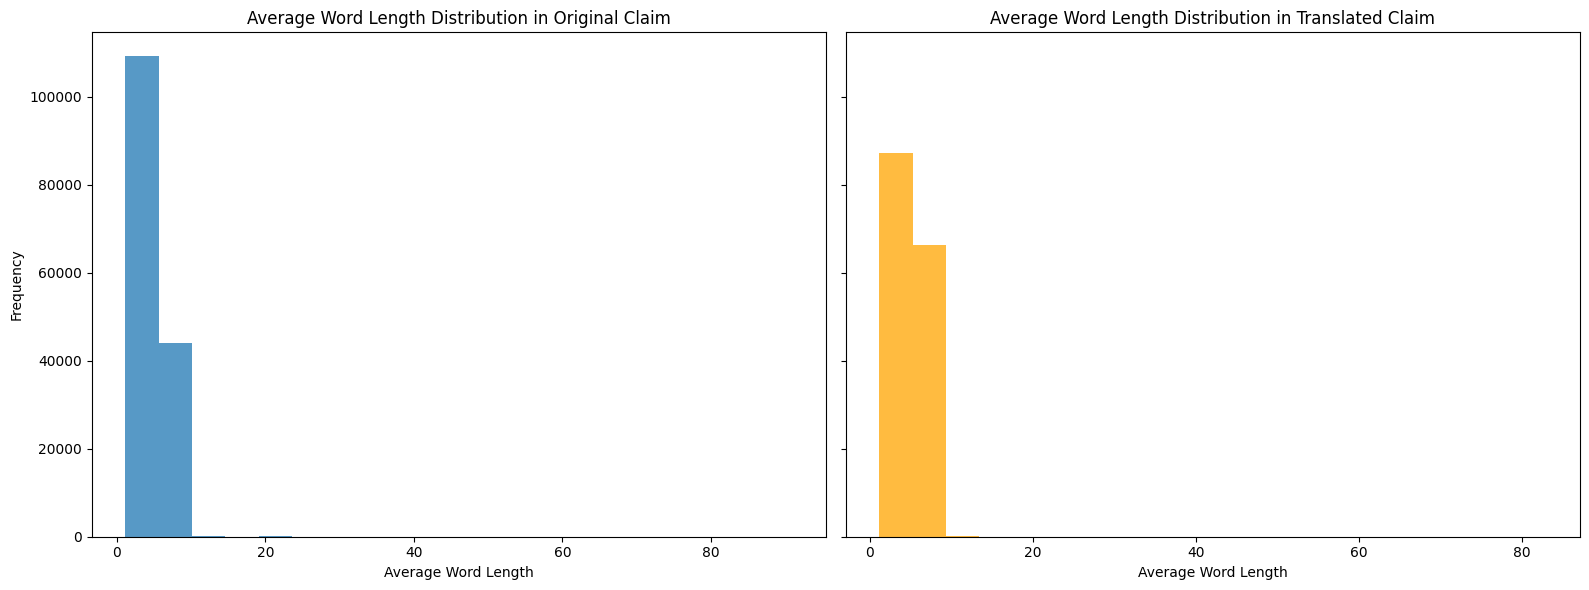

In [182]:
def plot_average_word_length_side_by_side(column1, column2, labels):
   
    avg_word_lengths1 = column1.dropna().str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x) if x else 0)
    avg_word_lengths2 = column2.dropna().str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x) if x else 0)
    

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)


    axes[0].hist(avg_word_lengths1, bins=20, alpha=0.75)
    axes[0].set_title(f"Average Word Length Distribution in {labels[0]}")
    axes[0].set_xlabel("Average Word Length")
    axes[0].set_ylabel("Frequency")
    

    axes[1].hist(avg_word_lengths2, bins=20, alpha=0.75, color='orange')
    axes[1].set_title(f"Average Word Length Distribution in {labels[1]}")
    axes[1].set_xlabel("Average Word Length")


    plt.tight_layout()
    plt.show()


plot_average_word_length_side_by_side(
    fact_checks['original_claim'], 
    fact_checks['translated_claim'], 
    labels=['Original Claim', 'Translated Claim']
    
)




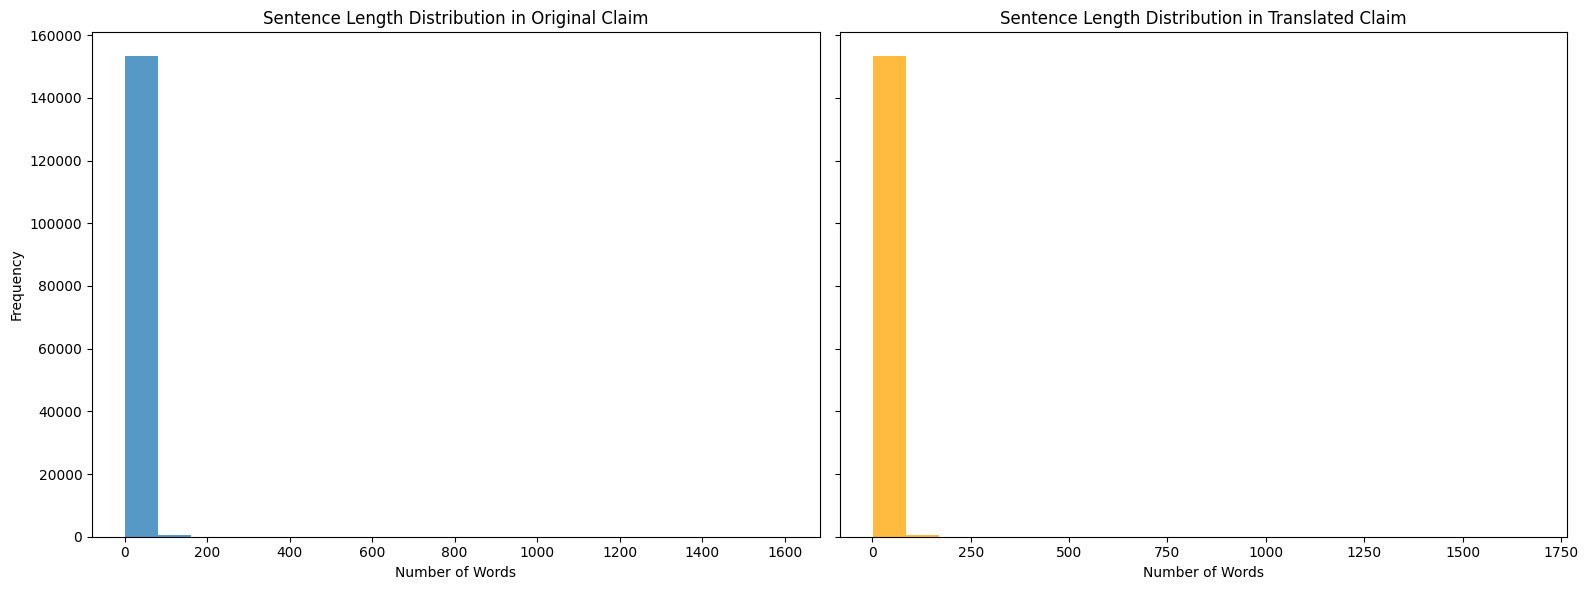

In [183]:
def plot_sentence_length_side_by_side(column1, column2, labels): # number of words in a sentence
  

    lengths1 = column1.dropna().apply(lambda x: len(x.split()))
    lengths2 = column2.dropna().apply(lambda x: len(x.split()))
    

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)


    axes[0].hist(lengths1, bins=20, alpha=0.75)
    axes[0].set_title(f"Sentence Length Distribution in {labels[0]}")
    axes[0].set_xlabel("Number of Words")
    axes[0].set_ylabel("Frequency")
    

    axes[1].hist(lengths2, bins=20, alpha=0.75, color='orange')
    axes[1].set_title(f"Sentence Length Distribution in {labels[1]}")
    axes[1].set_xlabel("Number of Words")


    plt.tight_layout()
    plt.show()


plot_sentence_length_side_by_side(
    fact_checks['original_claim'], 
    fact_checks['translated_claim'], 
    labels=['Original Claim', 'Translated Claim']
)


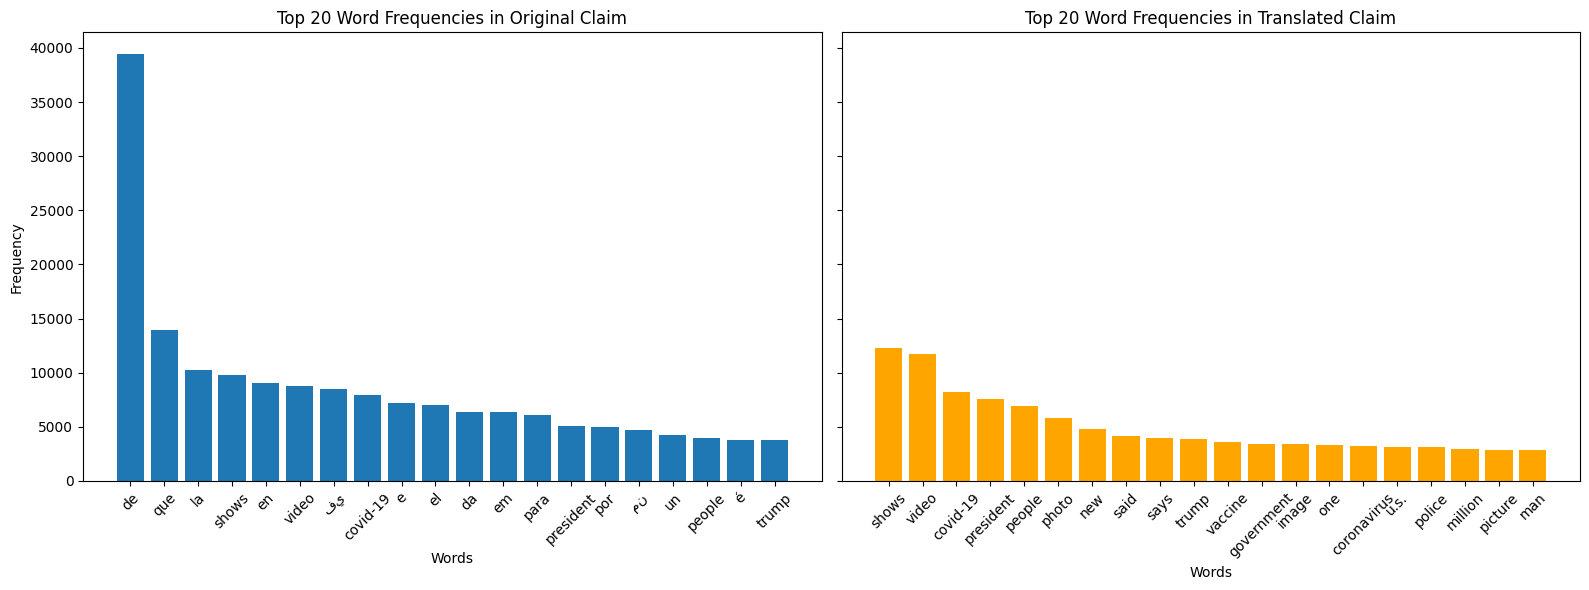

In [184]:
def plot_word_frequencies_side_by_side(column1, column2, labels, top_k=20):
    stop_words = set(stopwords.words('english'))
    

    text1 = ' '.join(column1.dropna()).lower()
    words1 = [word for word in text1.split() if word not in stop_words and word not in string.punctuation]
    word_freq1 = Counter(words1).most_common(top_k)
    words1, counts1 = zip(*word_freq1)
    
    
    text2 = ' '.join(column2.dropna()).lower()
    words2 = [word for word in text2.split() if word not in stop_words and word not in string.punctuation]
    word_freq2 = Counter(words2).most_common(top_k)
    words2, counts2 = zip(*word_freq2)
    

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    

    axes[0].bar(words1, counts1)
    axes[0].set_title(f"Top {top_k} Word Frequencies in {labels[0]}")
    axes[0].set_xlabel("Words")
    axes[0].set_ylabel("Frequency")
    axes[0].tick_params(axis='x', rotation=45)
    

    axes[1].bar(words2, counts2, color='orange')
    axes[1].set_title(f"Top {top_k} Word Frequencies in {labels[1]}")
    axes[1].set_xlabel("Words")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


plot_word_frequencies_side_by_side(
    fact_checks['original_claim'], 
    fact_checks['translated_claim'], 
    labels=['Original Claim', 'Translated Claim'], 
    top_k=20
)



In [ ]:
def generate_ngrams(text, n):

  if not text:
    return []
  tokens = text.split()
  ngrams = []
  for i in range(len(tokens) - n + 1):
    ngrams.append(' '.join(tokens[i:i+n]))
  return ngrams

def evaluate_ngrams(df, text_column, n):

  ngram_counts = {}
  for text in df[text_column]:
    if isinstance(text, str):
      for ngram in generate_ngrams(text, n):
        if ngram in ngram_counts:
          ngram_counts[ngram] += 1
        else:
          ngram_counts[ngram] = 1
  return ngram_counts

n = 3  

text_ngrams = evaluate_ngrams(posts, 'text_original', n)
claim_ngrams = evaluate_ngrams(fact_checks, 'original_claim', n)
ocr_ngrams = evaluate_ngrams(posts, 'ocr_original', n)

print(f"Top 10 {n}-grams in text:")
sorted_post_ngrams = dict(sorted(text_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_post_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in claims:")
sorted_claim_ngrams = dict(sorted(claim_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_claim_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in ocr:")
sorted_text_ngrams = dict(sorted(ocr_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_text_ngrams.items())[:10]:
  print(f"{ngram}: {count}")



Top 10 3-grams in text:
. . .: 340
[USER] [USER] [USER]: 268
bobi wine free: 124
wine free bobi: 124
free bobi wine: 123
de lo que: 119
a través de: 86
el uso de: 80
one of the: 79
uno de los: 79

Top 10 3-grams in claims:
A photograph shows: 987
President Donald Trump: 815
A video shows: 619
the image shows: 472
photograph shows a: 466
video shows a: 444
U.S. President Donald: 419
the United States: 406
President Joe Biden: 345
image shows a: 333

Top 10 3-grams in ocr:
Twitter for iPhone: 175
Twitter for Android: 156
Tik Tok [USER]: 140
Twitter Web App: 130
World Health Organization: 72
0 0 0: 65
NO USAR NO: 62
USAR NO USAR: 61
Donald J. Trump: 53
be able to: 45


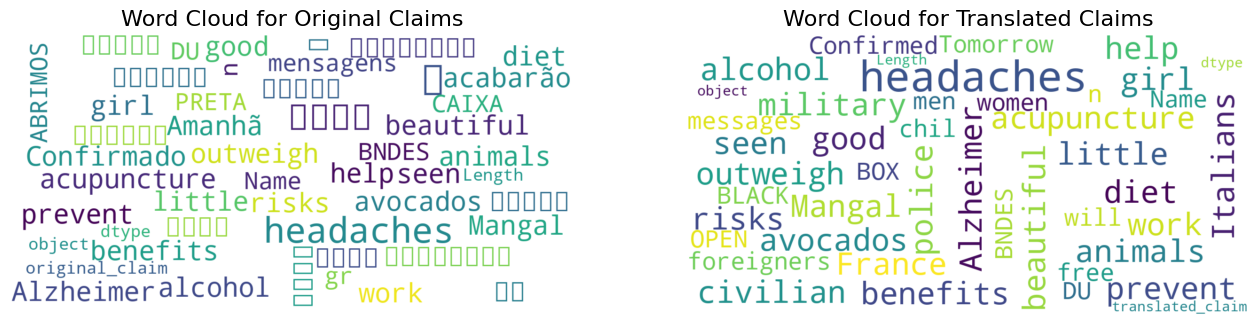

In [186]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
def show_wordcloud_side_by_side(column1, column2, title1="Column 1", title2="Column 2"):
    
    wordcloud1 = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1
    ).generate(str(column1))

    wordcloud2 = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1
    ).generate(str(column2))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(wordcloud1, interpolation="bilinear")
    axes[0].set_title(title1, fontsize=16)
    axes[0].axis("off")

    axes[1].imshow(wordcloud2, interpolation="bilinear")
    axes[1].set_title(title2, fontsize=16)
    axes[1].axis("off")

    plt.show()


show_wordcloud_side_by_side(
    fact_checks['original_claim'],
    fact_checks['translated_claim'],
    title1="Word Cloud for Original Claims",
    title2="Word Cloud for Translated Claims"
)

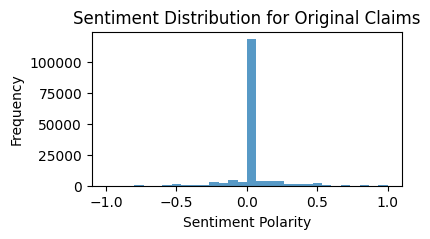

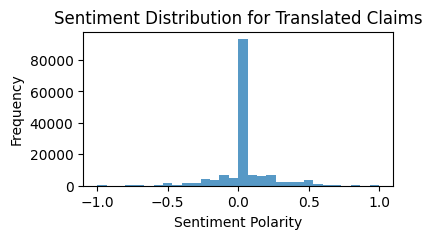

In [187]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt

def analyze_sentiment_textblob(text_column):
   
    sentiment_scores = text_column.dropna().apply(lambda x: TextBlob(x).sentiment.polarity)
    return sentiment_scores

def plot_sentiment(sentiment_scores, title="Sentiment Distribution"):
  
    plt.figure(figsize=(4, 2))
    plt.hist(sentiment_scores, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("Frequency")
    plt.show()


original_claim_sentiment = analyze_sentiment_textblob(fact_checks['original_claim'])
plot_sentiment(original_claim_sentiment, title="Sentiment Distribution for Original Claims")


translated_claim_sentiment = analyze_sentiment_textblob(fact_checks['translated_claim'])
plot_sentiment(translated_claim_sentiment, title="Sentiment Distribution for Translated Claims")


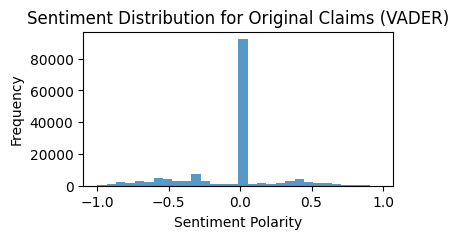

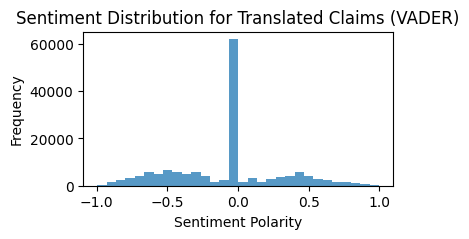

In [188]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_sentiment_vader(text_column):
    """
    Analyze sentiment using VADER and return a DataFrame with sentiment scores.
    """
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = text_column.dropna().apply(lambda x: analyzer.polarity_scores(x)['compound'])
    return sentiment_scores


original_claim_sentiment_vader = analyze_sentiment_vader(fact_checks['original_claim'])
plot_sentiment(original_claim_sentiment_vader, title="Sentiment Distribution for Original Claims (VADER)")

translated_claim_sentiment_vader = analyze_sentiment_vader(fact_checks['translated_claim'])
plot_sentiment(translated_claim_sentiment_vader, title="Sentiment Distribution for Translated Claims (VADER)")


HERE WE ANALYZE POSTS.CSV

In [189]:
plot_word_frequencies_side_by_side(
    posts['text_original'], 
    posts['text_translated'], 
    labels=['Original text', 'Translated text'], 
    top_k=20
)




AttributeError: 'set' object has no attribute 'words'

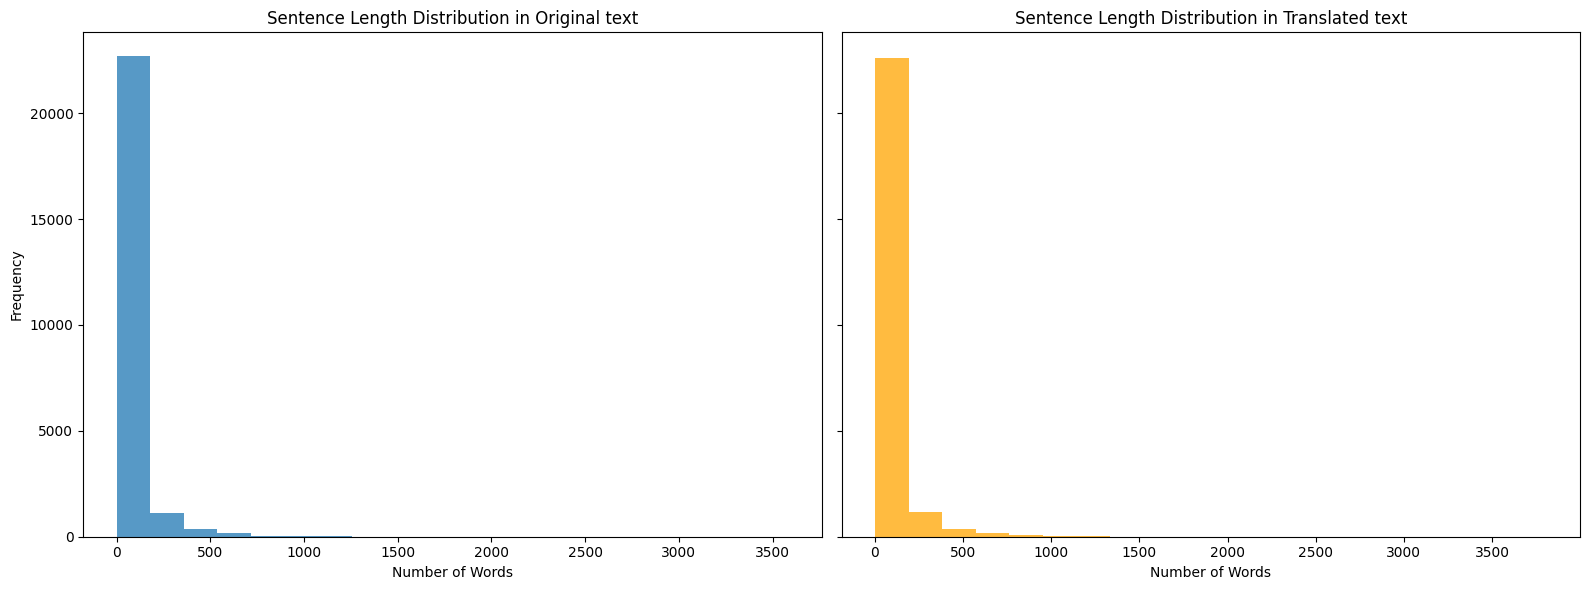

In [ ]:
plot_sentence_length_side_by_side(
    posts['text_original'], 
    posts['text_translated'], 
    labels=['Original text', 'Translated text']
)

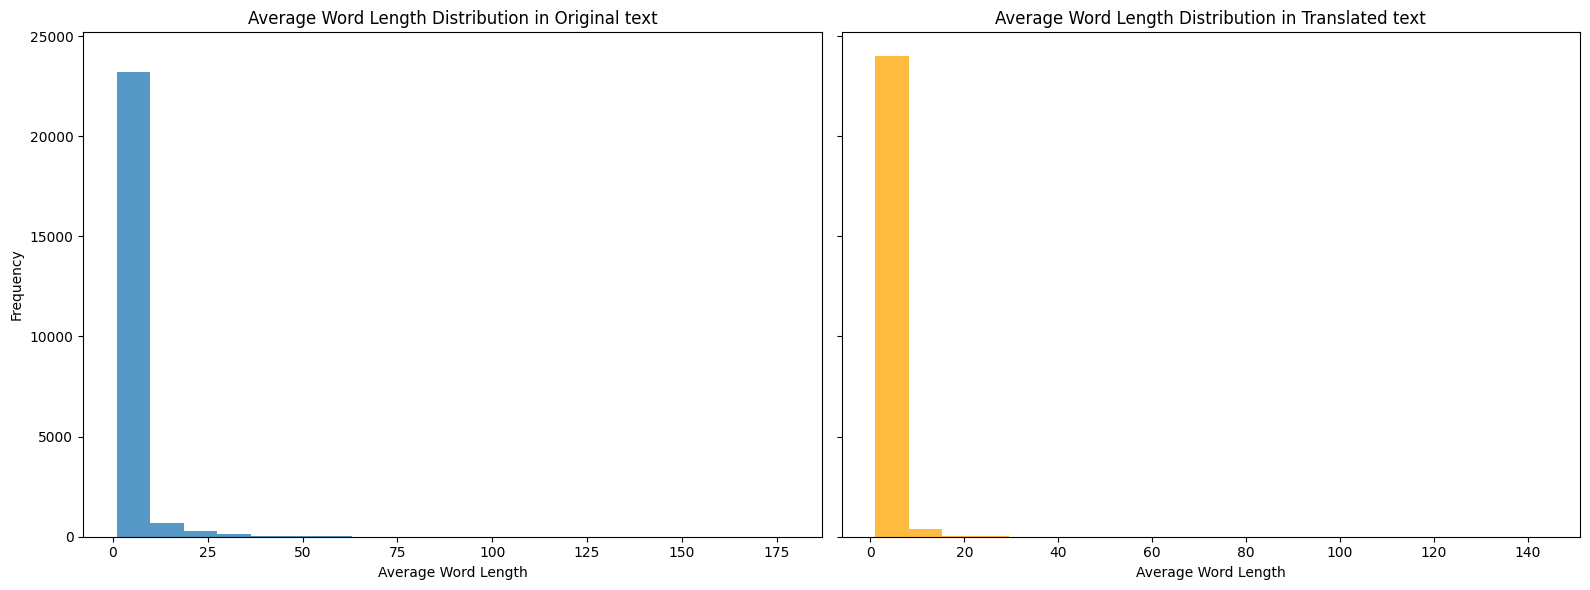

In [ ]:
plot_average_word_length_side_by_side(
    posts['text_original'], 
    posts['text_translated'], 
    labels=['Original text', 'Translated text']
    
)

In [ ]:
n = 3 

text_ngrams = evaluate_ngrams(posts, 'text_translated', n)
claim_ngrams = evaluate_ngrams(fact_checks, 'translated_claim', n)
ocr_ngrams = evaluate_ngrams(posts, 'ocr_translated', n)

print(f"Top 10 {n}-grams in text:")
sorted_post_ngrams = dict(sorted(text_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_post_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in claims:")
sorted_claim_ngrams = dict(sorted(claim_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_claim_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in ocr:")
sorted_text_ngrams = dict(sorted(ocr_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_text_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

Top 10 3-grams in text:
one of the: 448
This is the: 402
. . .: 348
there is no: 323
be able to: 310
[USER] [USER] [USER]: 266
that it is: 265
the United States: 262
a lot of: 256
due to the: 228

Top 10 3-grams in claims:
A picture of: 1129
A photograph shows: 995
President Donald Trump: 872
A video clip: 731
A video shows: 708
one of the: 677
the United States: 639
due to the: 567
video shows a: 562
picture of the: 506

Top 10 3-grams in ocr:
Twitter for iPhone: 161
Twitter for Android: 144
Tik Tok [USER]: 116
one of the: 110
be able to: 108
the use of: 92
President of the: 92
World Health Organization: 91
DO NOT USE: 91
there is a: 84


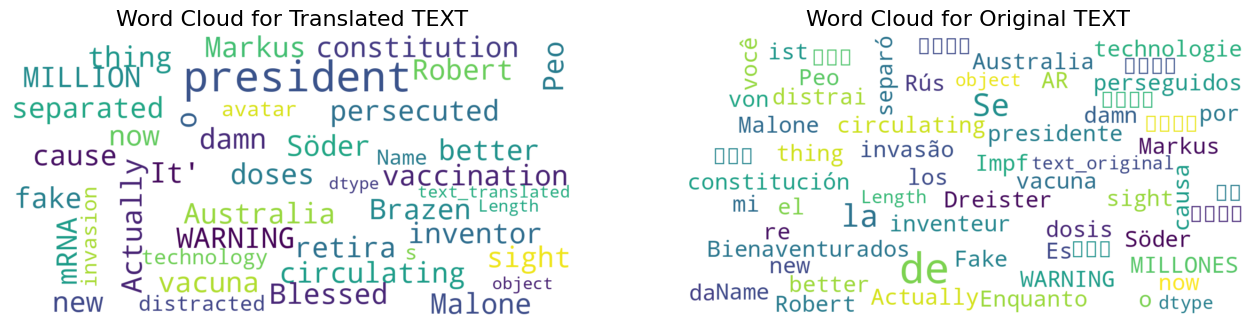

In [ ]:
show_wordcloud_side_by_side(
    posts['text_translated'],
    posts['text_original'],
    title1="Word Cloud for Translated TEXT",
    title2="Word Cloud for Original TEXT"
)



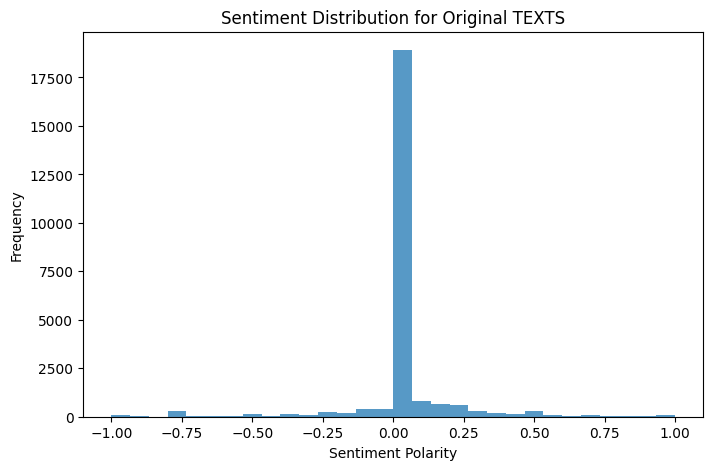

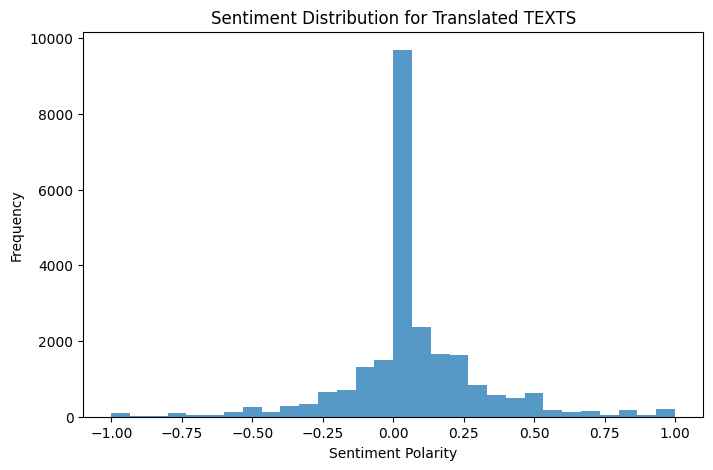

In [ ]:
original_claim_sentiment = analyze_sentiment_textblob(posts['text_original'])
plot_sentiment(original_claim_sentiment, title="Sentiment Distribution for Original TEXTS")


translated_claim_sentiment = analyze_sentiment_textblob(posts['text_translated'])
plot_sentiment(translated_claim_sentiment, title="Sentiment Distribution for Translated TEXTS")

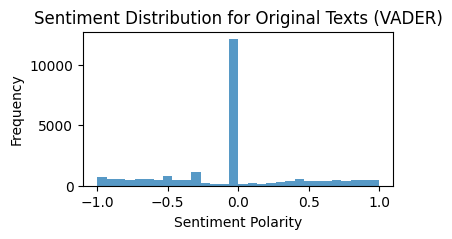

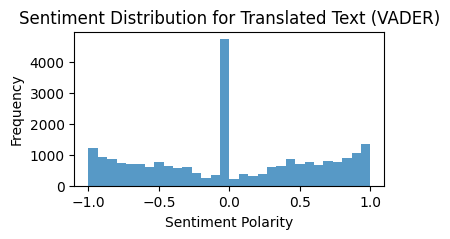

In [ ]:



original_claim_sentiment_vader = analyze_sentiment_vader(posts['text_original'])
plot_sentiment(original_claim_sentiment_vader, title="Sentiment Distribution for Original Texts (VADER)")


translated_claim_sentiment_vader = analyze_sentiment_vader(posts['text_translated'])
plot_sentiment(translated_claim_sentiment_vader, title="Sentiment Distribution for Translated Text (VADER)")


LET US APPLY PRE-PROCESSING METHODS AND EVALUATE word dist again


In [192]:
import re
import emoji
import pandas as pd
import ast
import pandas as pd
import re
from langdetect import detect
from collections import Counter
from sentencepiece import SentencePieceProcessor
import unicodedata

class TextPreprocessor:
    @staticmethod
    def remove_urls(text):
        if not isinstance(text, str):
            return text
        return re.sub(r'http\S+', '', text)

    @staticmethod
    def remove_emojis(text):
        if not isinstance(text, str):
            return text
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "]+",
            flags=re.UNICODE,
        )
        return emoji_pattern.sub(r'', text)

    @staticmethod
    def replace_whitespaces(text):
        if not isinstance(text, str):
            return text
        return re.sub(r'\s+', ' ', text).strip()

    def preprocess(self, text):
        text = self.remove_urls(text)
        text = self.remove_emojis(text)
        text = self.replace_whitespaces(text)
        return text


def remove_repeated_chars(text, threshold=0.4):
    """Remove texts with a high ratio of repeated characters."""
    if not isinstance(text, str):  # Ensure input is a string
        return text  # Return as is for non-string inputs

    char_counts = Counter(text)
    total_chars = sum(char_counts.values())
    repeated_ratio = max(char_counts.values()) / total_chars if total_chars > 0 else 0
    return text if repeated_ratio < threshold else None


def remove_repeated_words(text):

    if not isinstance(text, str) or text is None:  # Ensure the input is a valid string
        return text  # Return as is if not a string or None

    words = text.split()  # Split the string into words
    result = [words[0]] if words else []  # Initialize the result with the first word if exists

    for word in words[1:]:
        if word != result[-1]:  # Only add word if it's not a duplicate of the last one
            result.append(word)

    return ' '.join(result)  # Join the words back into a string


def remove_special_chars(text, threshold=0.3):
    if not isinstance(text, str):  # Handle None or non-string values
        return text  # Return as-is if not a string

    special_chars = sum(not char.isalnum() for char in text)
    total_chars = len(text)
    special_ratio = special_chars / total_chars if total_chars > 0 else 0
    return text if special_ratio < threshold else None


def remove_short_chunks(text, min_words=3):

    return text if len(text.split()) >= min_words else None

def deduplicate_sentences(df, text_column):

    df[text_column] = df[text_column].str.strip().str.lower()
    return df.drop_duplicates(subset=[text_column])




In [193]:
def preprocess_text_debug(series):
    """Debug each preprocessing step."""
    print("Original Series:")
    print(series.head())

    series = series.dropna()
    print("\nAfter dropna:")
    print(series.head())


    series = series.apply(lambda x: remove_repeated_words(x) if isinstance(x, str) else x)
    print("\nAfter remove_repeated_words:")
    print(series.head())

    series = series.apply(lambda x: remove_special_chars(x) if isinstance(x, str) else x)
    print("\nAfter remove_special_chars:")
    print(series.head())

    series = series.apply(lambda x: remove_short_chunks(x) if isinstance(x, str) else x)
    print("\nAfter remove_short_chunks:")
    print(series.head())

    series = series.dropna()
    print("\nAfter final dropna:")
    print(series.head())

    series = series.drop_duplicates()
    print("\nAfter drop_duplicates:")
    print(series.head())

    return series


In [194]:
preprocessor = TextPreprocessor()
columns_to_preprocess = [
        ('translated_claim', fact_checks),
        ('text_translated', posts),
        ('ocr_translated', posts),
        ('original_claim', fact_checks),
        ('text_original', posts),
        ('ocr_original', posts)
    ]
fact_checks2 = fact_checks
posts2 = posts



for col, df in columns_to_preprocess:
      if col in df.columns:
          df[col] = df[col].apply(preprocessor.preprocess)
          #df[col] = preprocess_text(df[col])
          df[col] = preprocess_text_debug(df[col])





Original Series:
0                        Are avocados good for you?
1                       Can animals have headaches?
2        Can we help prevent Alzheimer's with diet?
3    Do any benefits of alcohol outweigh the risks?
4              Does acupuncture work for headaches?
Name: translated_claim, dtype: object

After dropna:
0                        Are avocados good for you?
1                       Can animals have headaches?
2        Can we help prevent Alzheimer's with diet?
3    Do any benefits of alcohol outweigh the risks?
4              Does acupuncture work for headaches?
Name: translated_claim, dtype: object

After remove_repeated_words:
0                        Are avocados good for you?
1                       Can animals have headaches?
2        Can we help prevent Alzheimer's with diet?
3    Do any benefits of alcohol outweigh the risks?
4              Does acupuncture work for headaches?
Name: translated_claim, dtype: object

After remove_special_chars:
0              

Top 10 3-grams in text:
one of the: 435
This is the: 395
there is no: 321
be able to: 306
that it is: 260
the United States: 260
a lot of: 251
due to the: 227
in the world: 219
it is a: 216

Top 10 3-grams in claims:
A picture of: 1128
A photograph shows: 995
President Donald Trump: 871
A video clip: 731
A video shows: 708
one of the: 673
the United States: 638
due to the: 566
video shows a: 561
picture of the: 505

Top 10 3-grams in ocr:
Twitter for iPhone: 154
Twitter for Android: 139
one of the: 107
Tik Tok [USER]: 95
be able to: 93
World Health Organization: 91
DO NOT USE: 90
the use of: 86
Twitter Web App: 83
there is no: 79


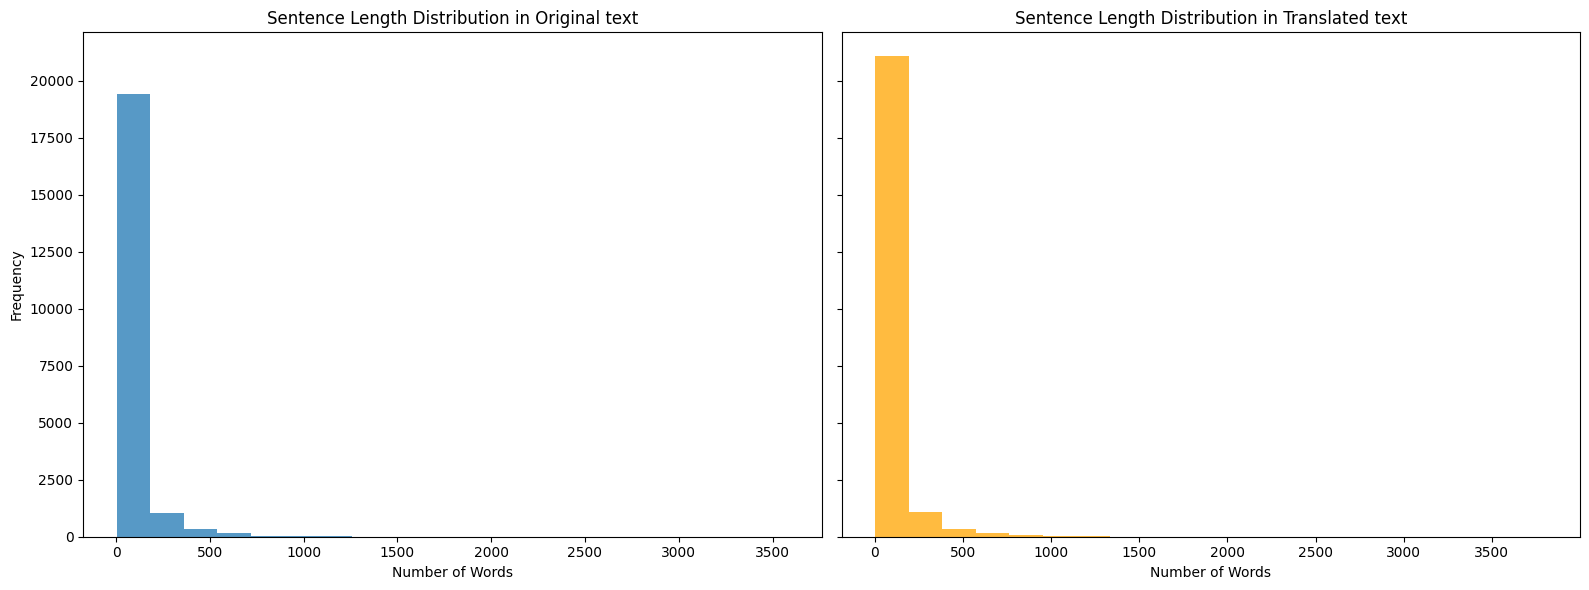

In [198]:
text_ngrams = evaluate_ngrams(posts, 'text_translated', n)
claim_ngrams = evaluate_ngrams(fact_checks, 'translated_claim', n)
ocr_ngrams = evaluate_ngrams(posts, 'ocr_translated', n)

print(f"Top 10 {n}-grams in text:")
sorted_post_ngrams = dict(sorted(text_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_post_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in claims:")
sorted_claim_ngrams = dict(sorted(claim_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_claim_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

print(f"\nTop 10 {n}-grams in ocr:")
sorted_text_ngrams = dict(sorted(ocr_ngrams.items(), key=lambda item: item[1], reverse=True))
for ngram, count in list(sorted_text_ngrams.items())[:10]:
  print(f"{ngram}: {count}")

plot_sentence_length_side_by_side(
    posts['text_original'], 
    posts['text_translated'], 
    labels=['Original text', 'Translated text']
)